# Analyzing the `lein-topology` function dependency network

## Automating recommendations to improve the software architecture

In [1]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import sand.graph as graph
import sand.cytoscape.app as app
import sand.cytoscape.positions as scp
import sand.modularity as mod

from sand.degree import degree_distribution_count
from sand.cytoscape.themes import ops, colors
from sand.csv import csv_to_dicts
from sand.groups import labels_to_groups, namespaces, fqn_to_groups, edge_betweenness

import matplotlib.pyplot as plt

%matplotlib notebook

### `graph.from_edges` with a list of dictionaries

Use `graph.from_edges` with an adjacency list consisting of two vertex names and an edge weight represented as a List of Dictionaries.

In [2]:
network_name = "5b2a6e3"
network_collection = "lein-topology"

data_path = "./data/" + network_collection + "-" + network_name
edgelist_file = data_path + ".csv"

edgelist_data = csv_to_dicts(edgelist_file,header=['source', 'target', 'weight'])
edgelist_data[:5]

[OrderedDict([('source', 'topology.dependencies/dependencies'),
              ('target', 'clojure.core/defn-'),
              ('weight', '1')]),
 OrderedDict([('source',
               'topology.edgelist-test/syntax-quotes-add-seq-concat-list'),
              ('target', 'clojure.core/filter'),
              ('weight', '1')]),
 OrderedDict([('source',
               'topology.dependencies-test/should-compute-fn-calls-in-namespace'),
              ('target', 'clojure.core/defn'),
              ('weight', '1')]),
 OrderedDict([('source', 'example/test-when'),
              ('target', 'clojure.core/cons'),
              ('weight', '1')]),
 OrderedDict([('source', 'leiningen.topology/topology'),
              ('target', 'org.clojure/clojure'),
              ('weight', '1')])]

In [3]:
g = graph.from_edges(edgelist_data)
g.summary()

'IGRAPH DNW- 107 206 -- \n+ attr: group (v), indegree (v), label (v), name (v), outdegree (v), weight (e)'

## Is the graph simple?

A graph is simple if it does not have multiple edges between vertices and has no loops, i.e. an edge with the same source and target vertex.

A graph that isn't simple can cause problems for some network analytics algorithms.

In [4]:
g.is_simple()

True

## Initial Clustering based on Namespace

Groups represent modules or communities in the network. Groups are based on the labels by default.

In [5]:
g.vs['group'][:5]

[69, 30, 43, 17, 95]

The vertices in the `lein topology` data set contain fully-qualified namespaces for functions. Grouping by name isn't particularly useful here:

In [6]:
len(set(g.vs['group']))

107

In [7]:
len(g.vs)

107

Because `sandbook` was build specifically for analyzing software and system networks, a `fqn_to_groups` grouping function is built in:

In [8]:
g.vs['group'] = fqn_to_groups(g.vs['label'])

In [9]:
len(set(g.vs['group']))

20

This is a much more managable number of groups.

Namespaces may also be useful as a separate attribute on the vertices:

In [10]:
g.vs['namespace'] = namespaces(g.vs['label'])

## Use degree centrality to identify candidates to filter from the analysis

Outdegree represents the vertices that have the most dependencies, i.e. call the most number of functions. These functions could potentially be split into smaller, more cohesive functions.

Indegree represents the vertices are depended on the most...changing them will have the most impact on other parts of the system.

In [11]:
degree, count = degree_distribution_count(g)

<IPython.core.display.Javascript object>


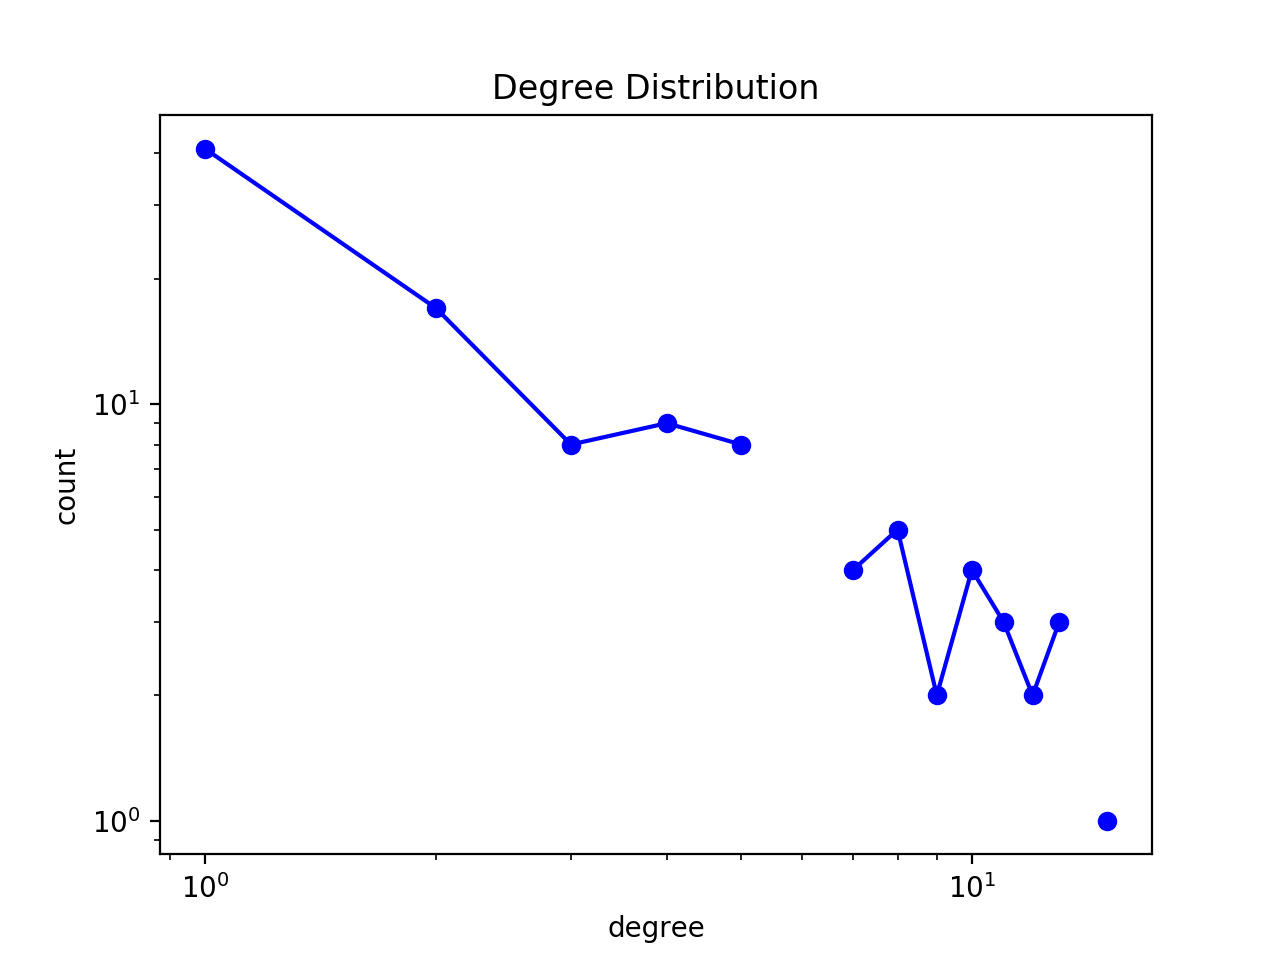

In [12]:
plt.title("Degree Distribution")
plt.ylabel("count")
plt.xlabel("degree")
infig, = plt.loglog(degree, count, 'b-', marker='o')

In [13]:
g.vs['outdegree'][:5]

[12, 0, 15, 0, 13]

In [14]:
g.vs['indegree'][:5]

[1, 12, 0, 7, 0]

Which vertices have a degree of more than some majority percentage of the maxdegree?

In [15]:
g.maxdegree(mode='IN')

13

In [16]:
g.maxdegree(mode='OUT')

15

In [17]:
score = g.maxdegree() * .80

### These functions call the highest number of others and could potentially be split:

In [18]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['outdegree'] >= 10)]

['topology.dependencies/dependencies',
 'topology.edgelist-test/syntax-quotes-add-seq-concat-list',
 'topology.dependencies-test/should-compute-fn-calls-in-namespace',
 'leiningen.topology/topology',
 'topology.symbols/seq-map-zip',
 'topology.dependencies/sources',
 'topology.qualifier/fq-ns']

### Changing these functions will have the most impact on other parts of the system:

In [19]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['indegree'] >= 4)]

['clojure.core/defn-',
 'clojure.core/filter',
 'clojure.core/defn',
 'clojure.core/seq',
 'clojure.core/fn',
 'clojure.core/meta',
 'clojure.core/=',
 'clojure.test/is',
 'clojure.core/symbol',
 'clojure.test/deftest',
 'clojure.core/->>',
 'clojure.core/range',
 'clojure.core/map',
 'clojure.core/list']

In this case, `clojure.core` and `clojure.test` namespaces have the most dependencies...unsurprising, given these are the foundational libraries of the language! These are good candidates to filter out of a visualization, since they often don't add deep insight to the aspects of the design specific to the program.

## Extract the subgraph of local namespaces based on our filter criteria

There are some analyses where it will be useful to see all the vertices. For the high-level architecture diagram, we can focus on the functions local to the library's namespaces. We'll also keep functions that have side-effects to see if these are isolated to only a few key parts of the program:

In [27]:
# List all patterns of vertex names that we want to keep:
names_to_keep = ('topology', 'clojure.core/*err*', 'clojure.core/println', 
                 'clojure.zip', 'clojure.java.io', 'clojure.tools.namespace',
                 'leiningen.core.eval', 'clojure.repl')

lv = g.vs(lambda v: any(match in v['label'] for match in names_to_keep))
lg = g.subgraph(lv)

# Recompute degree after building the local subgraph (lg):
lg.vs['indegree'] = lg.degree(mode="in")
lg.vs['outdegree'] = lg.degree(mode="out")

lg.summary()

'IGRAPH DNW- 35 35 -- \n+ attr: group (v), indegree (v), label (v), name (v), namespace (v), outdegree (v), weight (e)'

# Visualizing the network in Cytoscape

## Verify that Cytoscape is running and get the current version

In [28]:
app.print_version()

{
  "apiVersion": "v1",
  "cytoscapeVersion": "3.5.1"
}


 ## Load the network into Cytoscape with a default layout

In [29]:
# Create py2cytoscape client
cy = CyRestClient()

In [30]:
# Optional: delete existing Cytoscape sessions.
cy.session.delete()

In [31]:
# Load the network
network = cy.network.create_from_igraph(lg, name=network_name, collection=network_collection)

## Layout

In [32]:
# Apply default layout
cy.layout.apply(name='force-directed', network=network)

## Customize the style

Use one of the included themes, or build your own.

In [34]:
style = cy.style.create('Ops')
style.update_defaults(ops.settings)

# Map the label property in the igraph data to Cytoscape's NODE_LABEL visual property
style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

### Color vertices by namespace:

In [38]:
border_colors = {
  'topology.finder': colors.BRIGHT_YELLOW,
  'topology.dependencies': colors.BRIGHT_ORANGE,
  'topology.dependencies-test': colors.BRIGHT_ORANGE,
  'topology.qualifier': colors.BRIGHT_PURPLE,
  'topology.symbols': colors.BRIGHT_BLUE,
  'clojure.core': colors.BRIGHT_RED,
  'clojure.java.io': colors.BRIGHT_RED,
  'topology.printer': colors.BRIGHT_RED,
  'leiningen.topology': colors.BRIGHT_WHITE,
}

fill_colors = {
  'topology.finder': colors.DARK_YELLOW,
  'topology.dependencies': colors.DARK_ORANGE,
  'topology.dependencies-test': colors.DARK_ORANGE,
  'topology.qualifier': colors.DARK_PURPLE,
  'topology.symbols': colors.DARK_BLUE,
  'clojure.core': colors.DARK_RED,
  'clojure.java.io': colors.DARK_RED,
  'topology.printer': colors.DARK_RED,
  'leiningen.topology': colors.DARK_WHITE,
}

style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_FILL_COLOR', mappings=fill_colors)
style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_BORDER_PAINT', mappings=border_colors)

In [39]:
cy.style.apply(style, network)

## Load layout coordinates from a previous session

In [37]:
positions_file = data_path + "-positions.csv"
scp.layout_from_positions_csv(network, positions_file, cy)

## Save the updated layout coordinates if you make changes

A benefit of this workflow is the ability to manually tweak the algorithmic network layout in Cytoscape.

After making changes, save the coordinates for a later session:

In [40]:
scp.positions_to_csv(network=network, path=positions_file)

## Generate an SVG export

Position the network in Cytoscape the way you want it, then trigger this export.
When iterating, run all cells above, then all cells below this point to avoid race conditions with cytoscape's renderer.

In [41]:
# Hide all panels in the UI
app.hide_panels()

True

In [42]:
# Fit to the window:
cy.layout.fit(network=network)

In [43]:
view_id = network.get_views()[0]
view = network.get_view(view_id=view_id, format='view')

In [44]:
# Zoom out slightly:
view.update_network_view('NETWORK_SCALE_FACTOR', 0.65)

In [48]:
# Shift the network to the left:
view.update_network_view('NETWORK_CENTER_X_LOCATION', 150.0)

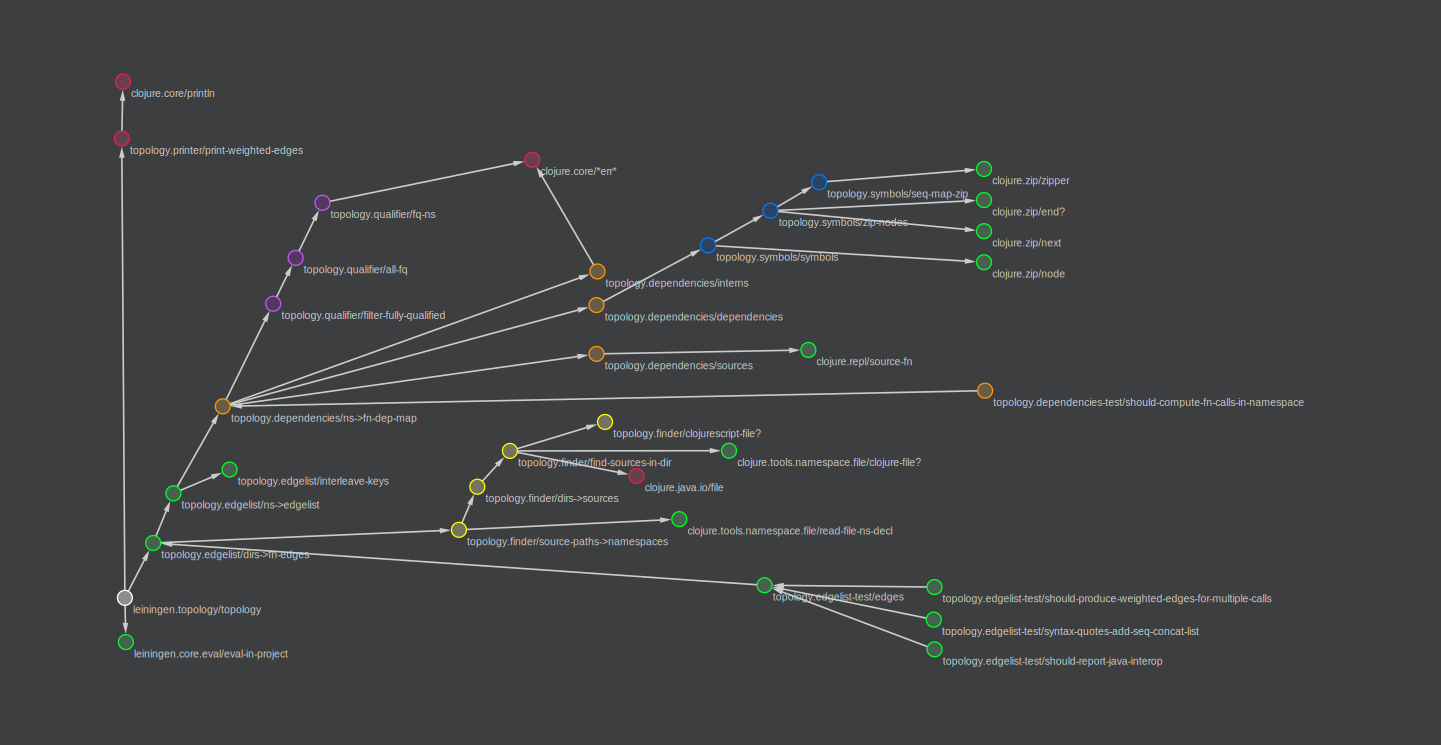

In [49]:
from IPython.display import SVG, display

svg_data = network.get_svg()
display(SVG(svg_data))

In [50]:
# Write the svg to a file if everything looks good:
with open(data_path + '.svg', 'wb') as f:
    f.write(svg_data)

## To create an updated structure after making new commits:

* Generate an updated network.
* Copy the previous position file to use as a starting point for the next visualization.
* Open Cytoscape or destroy existing collections if Cytoscape is already running.
* Run all cells to load the visualization.
* [Save the new layout if you make changes to node positions](/notebooks/architecture.ipynb#Save-the-updated-layout-coordinates-if-you-make-changes).

## Visualizing the network with a Dependency Structure Matrix (DSM)

Each row shows a function's dependencies.

Each column shows callers impacted by the function.

In [51]:
from sand.matrix import matrix

from bokeh.plotting import show, output_notebook
from bokeh.palettes import all_palettes

output_notebook()

Loading BokehJS ...

### Create a color palette

We want to choose a color palette so that groups stand out.

Find the number of groups that you have assigned to your vertices:

In [52]:
num_groups = max(set(lg.vs['group']))
num_groups

18

Now we need to [choose an appropriate palette](http://bokeh.pydata.org/en/latest/docs/reference/palettes.html) that accomodates this number of groups and achieves the desired visual separation.

As a general rule, you'll need one of the [large palettes](http://bokeh.pydata.org/en/latest/docs/reference/palettes.html#large-palettes) for > 20 groups.

Pass the name of the palette you choose to the `all_palettes` function:

In [53]:
palette = all_palettes['Category20'][num_groups + 1]

### Determine the order to sort the vertex labels

The matrix visualization will be rendered according to a vertex attribute used as the `sort_by` parameter in `matrix`.

In [54]:
lg.vs.attributes()

['name', 'indegree', 'outdegree', 'label', 'group', 'namespace']

### Render the matrix

In [55]:
p = matrix(lg, 'indegree', "{}-{} by indegree".format(network_collection, network_name), 900, palette)
show(p)

In [56]:
p = matrix(lg, 'outdegree', "{}-{} by outdegree".format(network_collection, network_name), 900, palette)
show(p)

In [57]:
p = matrix(lg, 'group', "{}-{} by group".format(network_collection, network_name), 900, palette)
show(p)

## Organizing the system by scoring coupling and cohesion

### Intuition

Ordering by group / modules gives us a visual indication of how well the system accomplishes the design goal of loosely coupled and highly cohesive modules. We can quantify this idea.

Clustering is a type of assignment problem seeking the optimal allocation of N components to M clusters. One of the prominent heuristics of system architecting is to choose modules such that they are as independent as possible...low coupling and high cohesion.

We can objectively score these clustering algorithms using an objective function that considers both the size of the clusters ($C_i$) and the number of interactions outside the clusters ($I_0$) according to the following equation, where $\alpha = 10$, $\beta = 100$ or $\alpha = 1$, $\beta = 10$, and $M$ is the number of clusters:

$Obj = \alpha \sum_{i=1}^{M}C_i^2 + \beta I_0$

_See page 25 of Design Structure Matrix Methods and Applications for more information._

Clustering objectives work against two competing forces:

* We want to minimize the size of the largest modules...otherwise, we could just take the trivial result of putting everything into one module. M=1
* We want to minimize the number and/or strength of interactions among components that cross the module boundaries. As we get to more components, more and more interactions will be required to cross module boundaries. The extreme result would be M=N.

The objective function could be evaluated for any number of potential designs that were manually or automatically created. This essentially provides a real-time feedback loop about the potential quality of a design. The range of the function is immediately bound by the two extremes. Your job as an architect and designer is to minimize this function.

### Scoring `lein-topology`

For us to apply this scoring methodology meaningfully, we'll make a couple of simplifying assumptions:

* `clojure.core` functions aren't moving to a different namespace.
* tests shouldn't factor in to how the system is structured.

With these, we can apply the filtering from above a bit more strictly to get an even smaller subgraph of the function call network:

In [59]:
v_to_keep = g.vs(lambda v: 'topology' in v['label'] and not 'test' in v['label'])
tg = g.subgraph(v_to_keep)

# Recompute degree after building the subgraph:
tg.vs['indegree'] = tg.degree(mode="in")
tg.vs['outdegree'] = tg.degree(mode="out")

tg.summary()

'IGRAPH DNW- 19 18 -- \n+ attr: group (v), indegree (v), label (v), name (v), namespace (v), outdegree (v), weight (e)'

The baseline modularity score of `lein-topology`'s core function dependency graph is:

In [60]:
mod.objective(tg, tg.vs['group'])

121

Where is this on the range of possibilities? 

Suppose all functions were in the same namespace. We'll simulate this by setting the group membership vector to all 1's:

In [61]:
mod.objective(tg, [1 for _ in range(len(tg.vs))])

361

This is the degenerate case of M=1, so the objective function simply returns the square of the number of vertices:

In [62]:
len(tg.vs) * len(tg.vs)

361

The other extreme occurs when we have the extreme of M=N, or all functions in their own namespace. We can simulate this by providing a unique group membership id for each vertex:

In [63]:
mod.objective(tg, range(len(tg.vs)))

199

Finally, we can compare our actual modularity score to a computational result. We can use Girvan-Newman edge-betweenness community detection to generate a modular design based on the network structure alone:

In [64]:
eb_membership = edge_betweenness(tg, directed=True)

In [65]:
len(set(eb_membership))

4

In [66]:
len(set(tg.vs['group']))

7

So the edge betweenness algorithm comes up with fewer communities, i.e. namespace in this context. Let's see how the modularity score compares:

In [67]:
mod.objective(tg, eb_membership)

133

If this score is lower than our actual baseline, than the computational community structure may represent an improvement over the current structure. Which namespaces have changed groups? We may wish to refactor the code to reflect this structure.

If the edge betweenness modularity score is higher than our baseline, this fact acts as a quantitative defense of our design.

### The novelty here is receiving an algorithmic recommendation about how to improve the organization of the code.